# Toolkit Showcase: Prepare and run a protein-ligand simulation

Welcome to the Open Force Field Toolkit! This introductory example will demonstrate how to prepare a system for Molecular Dynamics that combines solvent, a ligand using the Sage open force field, and a protein using a standard Amber force field. We'll take a pre-docked benchmark example and solvate it, assemble the system, parametrize it, and finally simulate it with OpenMM and visualize the results, all without leaving the notebook. Have fun!

In [1]:
# Imports from the comp chem ecosystem
import mdtraj
import nglview
import numpy as np
import openmm
from openff.units import Quantity, unit
from openmm import unit as openmm_unit
from pdbfixer import PDBFixer

# Imports from the toolkit
from openff.toolkit import ForceField, Molecule, Topology

%env OMP_NUM_THREADS=2

env: OMP_NUM_THREADS=2


## Introducing the main cast

Merck [provides data] to benchmark Free Energy Perturbation (FEP) procedures. We'll use structures from this dataset for this showcase:

<https://github.com/MCompChem/fep-benchmark>

This example is pre-packaged with one protein-ligand complex from the above repository, however you should be able to download other complexes and run them as well using this workflow. PT2385, our ligand of choice, is an antagonist of the HIF2α protein, a transcription factor that is stabilized in many kidney cancers.

The ligand and protein structures are already prepared for simulation:

- Their co-ordinates are super-imposable
- Hydrogens have been added to protein and crystallographic waters
- The protein's termini are capped with N-methyl and acetyl groups to prevent unphysical charges
- Atoms missing from the crystal structure have been replaced

<br />
<details>
<summary><small>▼ Click here for the shell commands we used to download the protein-ligand complex</small></summary>
    
```shell
# Clone the repository
git clone https://github.com/MCompChem/fep-benchmark.git
# Take the last ligand from the hif2a benchmark
tail -n90 fep-benchmark/hif2a/ligands.sdf > PT2385.sdf
# Take the prepared protein structure
cp fep-benchmark/hif2a/5tbm_prepared.pdb .
```  

</details>

[provides data]: https://github.com/MCompChem/fep-benchmark
[PT2385]: https://doi.org/10.1158/0008-5472.CAN-16-0473

In [2]:
receptor_path = "5tbm_prepared.pdb"
ligand_path = "PT2385.sdf"

We can visualize each structure using the [NGLview] widget. These visualizations are interactive; rotate by dragging the left mouse button, pan with the right mouse button, and zoom with the scroll wheel. You can also mouse over an atom to see its details, and click an atom to center the view on it. When you mouse over the widget, a full screen button will appear in its top right corner.

[NGLview]: https://github.com/nglviewer/nglview

In [3]:
view = nglview.show_structure_file(ligand_path)
view

NGLWidget()

<div class="alert alert-info" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    ℹ️ Try replacing <code>ligand_path</code> with <code>receptor_path</code> to visualize the protein!
</div>


# The plan:

| Action | Software|
|--|--|
| Assemble and solvate the topology | PDBFixer, and OpenFF Toolkit
| Visualize the complex | OpenFF Toolkit and NGLview
| Parametrize the complex | OpenFF Toolkit and Interchange
| Simulate the complex | OpenMM
| Visualize the simulation | NGLview and MDTraj


## Assemble and solvate the topology (PDBFixer, and the toolkit)

Conceptually, this step involves putting together the positions of all of the components of the system. We'll create  a [`Topology`] to keep track of the contents of our system. A `Topology` represents a collection of molecules; it doesn't have any association with any force field parameters.

[`Topology`]: https://docs.openforcefield.org/projects/toolkit/en/stable/api/generated/openff.toolkit.topology.Topology.html

First, we'll load the ligand and receptor into OpenFF Toolkit [`Molecule`] objects, which keep track of all their chemical information. A `Molecule` represents a collection of atoms with specified formal charges, connected by bonds with specified bond orders, optionally including any number of conformer coordinates. This is intended to closely align with a chemist's intuitive understanding of a molecule, rather than simply wrap the minimal information needed for a calculation.

SDF files include all a molecule's bond orders and formal charges, as well as coordinates, so they're ideal as a format for distributing small molecules. And that's exactly the format the ligand is stored in!

[`Molecule`]: https://docs.openforcefield.org/projects/toolkit/en/stable/api/generated/openff.toolkit.topology.Molecule.html

CS(=O)(=O)c1ccc(c2c1[C@@H](C(C2)(F)F)O)Oc3cc(cc(c3)F)C#N


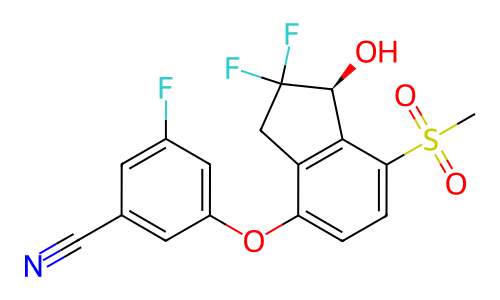

In [4]:
# Load a molecule from a SDF file
ligand = Molecule.from_file(ligand_path)

# Print out a SMILES code for the ligand
print(ligand.to_smiles(explicit_hydrogens=False))

# Visualize the molecule
ligand.visualize(show_all_hydrogens=False)

An SDF file with an entire protein would be huge, and finding or constructing one in the first place would be tricky, so for polymers the Toolkit supports inferring chemical information from PDB files. Connectivity can be taken from residue and atom names for supported molecules, and we can supply a list of arbitrary molecules that are in the PDB which are then identified via CONECT records.

First we'll solvate our system. [PDBFixer] makes it easy to add water and salt to our original receptor PDB, which already includes crystallographic waters. PDBFixer can also manage a number of other common processes, like restoring missing hydrogens or other atoms and even adding a membrane. We can then save it to disk and load the resulting PDB into a topology!

[PDBFixer]: https://htmlpreview.github.io/?https://github.com/openmm/pdbfixer/blob/master/Manual.html

In [5]:
fixer = PDBFixer(receptor_path)
fixer.addSolvent(
    padding=1.0 * openmm_unit.nanometer, ionicStrength=0.15 * openmm_unit.molar
)

with open("receptor_solvated.pdb", "w") as f:
    openmm.app.PDBFile.writeFile(fixer.topology, fixer.positions, f)

top = Topology.from_pdb("receptor_solvated.pdb")

We can finish up by adding the ligand `Molecule` to the topology, and removing any waters that clash with it. We can define a nice function for this.

In [6]:
def insert_molecule_and_remove_clashes(
    topology: Topology,
    insert: Molecule,
    radius: Quantity = 1.5 * unit.angstrom,
    keep: list[Molecule] = [],
) -> Topology:
    """
    Add a molecule to a copy of the topology, removing any clashing molecules.

    The molecule will be added to the end of the topology. A new topology is
    returned; the input topology will not be altered. All molecules that
    clash will be removed, and each removed molecule will be printed to stdout.
    Users are responsible for ensuring that no important molecules have been
    removed; the clash radius may be modified accordingly.

    Parameters
    ==========
    top
        The topology to insert a molecule into
    insert
        The molecule to insert
    radius
        Any atom within this distance of any atom in the insert is considered
        clashing.
    keep
        Keep copies of these molecules, even if they're clashing
    """
    # We'll collect the molecules for the output topology into a list
    new_top_mols = []
    # A molecule's positions in a topology are stored as its zeroth conformer
    insert_coordinates = insert.conformers[0][:, None, :]
    for molecule in topology.molecules:
        if any(keep_mol.is_isomorphic_with(molecule) for keep_mol in keep):
            new_top_mols.append(molecule)
            continue
        molecule_coordinates = molecule.conformers[0][None, :, :]
        diff_matrix = molecule_coordinates - insert_coordinates

        # np.linalg.norm doesn't work on Pint quantities 😢
        working_unit = unit.nanometer
        distance_matrix = (
            np.linalg.norm(diff_matrix.m_as(working_unit), axis=-1) * working_unit
        )

        if distance_matrix.min() > radius:
            # This molecule is not clashing, so add it to the topology
            new_top_mols.append(molecule)
        else:
            print(f"Removed {molecule.to_smiles()} molecule")

    # Insert the ligand at the end
    new_top_mols.append(ligand)

    # This pattern of assembling a topology from a list of molecules
    # ends up being much more efficient than adding each molecule
    # to a new topology one at a time
    new_top = Topology.from_molecules(new_top_mols)

    # Don't forget the box vectors!
    new_top.box_vectors = topology.box_vectors
    return new_top


top = insert_molecule_and_remove_clashes(top, ligand)

Now that we've assembled our topology, we can save it to disk. We can use JSON for this, which makes it human readable in a pinch. This stores everything we've just assembled - molecular identities, conformers, box vectors, and everything else. The topology can then be loaded later on with the [`Topology.from_json()`] method. This is great for running the same system through different force fields, moving files from workstations to HPC, distribution with a paper, or for assembling systems in stages.

[`Topology.from_json()`]: https://docs.openforcefield.org/projects/toolkit/en/stable/api/generated/openff.toolkit.topology.Topology.html#openff.toolkit.topology.Topology.from_json

In [7]:
with open("topology.json", "w") as f:
    print(top.to_json(), file=f)

## Visualize the complex (NGLview)

To visualize inside the notebook, we'll use `Topology.visualize`, which uses NGLview under the hood. NGLview supports a wide variety of [molecular visualization methods], as well as a VMD-like [atom selection language]. This can be used to visualize complex systems like this one.

The widget consists of a minimally documented [Python library frontend] and an extensively documented [JavaScript backend]. You'll need to refer to the documentation for both to do anything sophisticated, as the Python code delegates most of its options and functionality to the JS code.

By default, the toolkit attemps to draw some components with special representations:
* Waters: [line](https://nglviewer.org/ngl/api/manual/molecular-representations.html#line)
* Ions: [spacefill](https://nglviewer.org/ngl/api/manual/molecular-representations.html#spacefill)
* Proteins: [cartoon](https://nglviewer.org/ngl/api/manual/molecular-representations.html#cartoon)

Everything else (i.e. unrecognized ligands) are drawn with the [licorice](https://nglviewer.org/ngl/api/manual/molecular-representations.html#licorice) representation, which is basically a ball+stick model. A box representing the periodic boundary conditions is also added.

[molecular visualization methods]: https://nglviewer.org/ngl/api/manual/molecular-representations.html
[atom selection language]: https://nglviewer.org/ngl/api/manual/selection-language.html
[Python library frontend]: https://nglviewer.org/nglview/latest/api.html
[JavaScript backend]: https://nglviewer.org/ngl/api/manual/index.html

In [8]:
view = top.visualize()

# can make further modifications to this representation object, or just look at it
view

NGLWidget()

<div class="alert alert-info" style="max-width: 700px; margin-left: auto; margin-right: auto;">
ℹ️ Have a play with this visualization! Try clearing the default representations with <code>view.clear()</code> and configuring your own cartoon <em>(Hint: <a href=https://nglviewer.org/nglview/latest/api.html#nglview.NGLWidget>Check</a> the <a href=https://nglviewer.org/ngl/api/manual/molecular-representations.html>docs</a>)</em>. See if you can display the ligand in a way you like, without also displaying the protein's terminal caps. When you're happy with what you've made, save the image with <code>view.download_image()</code>
</div>

## Assemble the force field (OpenFF Toolkit)

Now that we've prepared our co-ordinates, we should choose the force field. For now, we don't have any single SMIRNOFF force field that can handle both proteins and small molecules; the Rosemary 3.0.0 force field will support this, but it's not expected until 2023. As an alternative, we'll combine the Sage small molecule force field with the SMIRNOFF port of Amber ff14SB. These force fields parametrize non-bonded parameters in similar ways and with the same functional form, so we don't expect any outrageous artifacts, but they also haven't been carefully tested together.

The star of the show here is the Sage 2.0.0 force field. [Sage] is the latest force field produced by the Open Force Field Initiative. Rather than using atom types like traditional biomolecular force fields, Sage assigns parameters to a molecule by [matching actual chemical moieties]. Note that to parametrize a molecule you need more than just the co-ordinates of its atoms; you also need their bonds, bond orders, and formal charges. As a result, `.sdf` files are used in this example; other file types are possible, but they must include this information. Sage is distributed as an `.offxml` file according to the [SMIRNOFF specification]. This file describes all the choices the toolkit has to make to parametrize a molecule. Sage also includes the TIP3P water model, which is appropriate for Amber ff14SB too.

When we combine multiple SMIRNOFF force fields into one, we provide them in an order from general to specific. Sage includes parameters that could be applied to a protein, but they're general across all molecules; ff14SB's parameters are specific to proteins. Since the Toolkit always applies the last parameters that match a moiety, this order makes sure the right parameters get assigned.

[Sage]: https://openforcefield.org/force-fields/force-fields/#sage
[matching actual chemical moieties]: https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html
[SMIRNOFF specification]: https://openforcefield.github.io/standards/standards/smirnoff/

<div class="alert alert-warning" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    🚧 <b> This code is not production-ready</b><br />
The Amber ff14SB port is intended as a proof-of-concept for SMIRNOFF protein force fields. It may not precisely match the energetics or forces of the original ff14SB, and it may not be appropriate in combination with Sage. Wait for protein support in the Rosemary force field to use this in production. 
</div>


In [9]:
sage_ff14sb = ForceField("openff-2.2.0.offxml", "ff14sb_off_impropers_0.0.4.offxml")

## Parametrize the complex (OpenFF Toolkit)

We now have a `Topology`, which stores the chemical information of the system, and a `ForceField`, which maps chemistry to force field parameters. To parametrize the system, we combine these two objects into an [`Interchange`].

An `Interchange` represents a completely parametrized molecular mechanics system. Partial charges are computed here according to the instructions in the force field, and this is where virtual sites required by the force field will be introduced. This all happens behind the scenes; all we have to do is combine an abstract chemical description with a force field. This makes it easy to change water model or force field, as the chemistry being modelled is completely independent of the model itself.

[`Interchange`]: https://docs.openforcefield.org/projects/interchange/en/stable/_autosummary/openff.interchange.components.interchange.Interchange.html

In [10]:
interchange = sage_ff14sb.create_interchange(top)

*(This should take about a minute, largely because of the complexity of the Amber protein force field port. In the future, this should be faster.)*

While that runs, let's recap. We've constructed a `Topology` out of a number of `Molecule` objects, each of which represents a particular chemical independent of any model details. The `Topology` then represents an entire chemical system, which in theory could be modelled in any number of ways. Our `Topology` also includes atom positions and box vectors, but if we thought that was too concrete for our use case we could leave them out and add them after parametrization.

Separately, we've constructed a `ForceField` by combining a general SMIRNOFF force field with a protein-specific SMIRNOFF force field. A SMIRNOFF force field is a bunch of rules for applying force field parameters to chemicals via SMARTS patterns. The force field includes everything needed to compute an energy: parameters, charges, functional forms, non-bonded methods and cutoffs, virtual sites, and so on.

Then, we've parametrized our `Topology` with our `ForceField` to produce an `Interchange`. This applies all our rules and gives us a system ready to simulate. An `Interchange` can also concretely define positions, velocities, and box vectors, whether they come from the `Topology` or are added after parametrization. Once we have the `Interchange`, we can produce input data for any of the supported MM engines.

This clear delineation makes benchmarking the same system against different force fields or the same force field against different force fields easy. The SMIRNOFF format makes distributing force fields in an engine agnostic way possible. Everything is an open standard or written in open source Python, so we can see how it works and even change it if we need to.

## Simulate the complex (OpenMM)

To use an `Interchange`, we need to convert it to the input expected by a particular molecular mechanics engine. We'll use OpenMM, because its support is the most mature and the fastest, but GROMACS, LAMMPS, and Amber all enjoy [preliminary support].

All that remains is to tell OpenMM the details about how we want to integrate and record data for the simulation, and then to put everything together and run it! 

[preliminary support]: https://docs.openforcefield.org/projects/interchange/en/stable/using/output.html

### Configure and run the simulation

Here, we'll use a Langevin thermostat at 300 Kelvin and a 2 fs time step. We'll write the structure to disk every 10 steps.

In [11]:
# Construct and configure a Langevin integrator at 300 K with an appropriate friction constant and time-step
integrator = openmm.LangevinIntegrator(
    300 * openmm_unit.kelvin,
    1 / openmm_unit.picosecond,
    0.002 * openmm_unit.picoseconds,
)

# Under the hood, this creates *OpenMM* `System` and `Topology` objects, then combines them together
simulation = interchange.to_openmm_simulation(integrator=integrator)

# Add a reporter to record the structure every 100 steps, 1000 if using a CUDA-enabled GPU
try:
    openmm.Platform.getPlatformByName("CUDA")
    stride = 1000
except openmm.OpenMMException:
    stride = 100

dcd_reporter = openmm.app.DCDReporter(file="trajectory.dcd", reportInterval=stride)
simulation.reporters.append(dcd_reporter)

### Minimize the combined system

This will reduce any forces that are too large to integrate, such as from clashes or from disagreements between the crystal structure and force field.


In [12]:
def describe_state(state: openmm.State, name: str = "State"):
    max_force = max(np.sqrt(v.x**2 + v.y**2 + v.z**2) for v in state.getForces())
    print(
        f"{name} has energy {round(state.getPotentialEnergy()._value, 2)} kJ/mol "
        f"with maximum force {round(max_force, 2)} kJ/(mol nm)"
    )


describe_state(
    simulation.context.getState(
        getEnergy=True,
        getForces=True,
    ),
    "Original state",
)

simulation.minimizeEnergy()

describe_state(
    simulation.context.getState(getEnergy=True, getForces=True),
    "Minimized state",
)

Original state has energy -190674.73 kJ/mol with maximum force 149153.8 kJ/(mol nm)
Minimized state has energy -404648.87 kJ/mol with maximum force 2427.74 kJ/(mol nm)


### Run a short simulation

If this were anything more than a demonstration of the Toolkit, this example would need to include additional steps like equilibration. 

<div class="alert alert-warning" style="max-width: 700px; margin-left: auto; margin-right: auto;">
⚠️ Make sure you use your own, valid simulation protocol! This is just an example.
</div>

In [13]:
simulation.context.setVelocitiesToTemperature(300 * openmm_unit.kelvin)
simulation.runForClockTime(1.0 * openmm_unit.minute)

_(This'll take a minute - literally, this time)_

While that runs, let's talk a bit about OpenFF

### Open Source Force Fields

A primary goal of the Open Force Field Initiative is to make development and use of force fields as open as possible - it's in our name! We believe that open source development practices have a lot to offer the scientific community, whether that science is academic, commercial, or hobbyist.

#### The SMIRNOFF specification

The SMIRNOFF specification describes a simple format for describing molecular force fields. We provide and maintain this spec in the hopes that it will allow scientists everywhere to contribute to force field development in a unified way, without taking them away from their favourite simulation package.

SMIRNOFF is not just a spec; we're also committed to a reference implementation — that being the OpenFF Toolkit. The Toolkit endeavors to support all the functional forms in both the SMIRNOFF spec and the [`openff-forcefields`](https://github.com/openforcefield/openff-forcefields/) package.

#### Reproducibility

OpenFF force fields are completely specified by the name of the distributed `.offxml` file. We use codenames, version numbers, and tags to accomplish this. This means that as long as a user, designer, or reviewer sees the name of the force field being used, they know exactly what is going in to that simulation. We include parameters that are often neglected in force field specifications, such as the non-bonded cut-off distance, ewald methods, constraints, modifications to the Lennard-Jones function, and partial charge generation methods are all defined by the name of the force field. 

As much as possible, we want energy and force to be a deterministic output of combining a molecule and a force field. If an author provides the name of the force field in their methods section, it should be reproducible. The other side of this coin is that we never want to hide the force field from the user. In all our workflows, the name of the force field must be explicitly provided in the code. This improves reproducibility of the code and helps the user take responsibility for their results. 

#### "Plugin" support for new force fields

The OpenFF Toolkit supports distributing force field files (.offxml) through Conda data packages. Anyone can publish a package on Conda Forge that extends the list of directories the toolkit searches for force fields, allowing anyone to produce force fields without requiring their own tooling, in a format that is designed to be converted to a multitude of simulation packages. See the [FAQ](https://open-forcefield-toolkit.readthedocs.io/en/stable/faq.html#how-can-i-distribute-my-own-force-fields-in-smirnoff-format) for more details.

---

Right! Simulation should be done by now, let's take a look.

## Visualize the simulation (nglview)

NGLview can display trajectories, as well as single structures. Mouse over the widget to see the animation controls.

In [14]:
trajectory: mdtraj.Trajectory = mdtraj.load(
    "trajectory.dcd", top=mdtraj.Topology.from_openmm(interchange.to_openmm_topology())
)

view = nglview.show_mdtraj(trajectory.image_molecules())
view.add_representation("line", selection="protein")
view

NGLWidget(max_frame=181)

<div class="alert alert-info" style="max-width: 700px; margin-left: auto; margin-right: auto;">
ℹ️ MDTraj is a great library for analysis. Check out the <a href=https://mdtraj.readthedocs.io/en/latest/api/generated/mdtraj.Trajectory.html#mdtraj.Trajectory>docs</a> for the <code>Trajectory</code> object you just created, as well as their <a href=https://mdtraj.readthedocs.io/en/latest/analysis.html>analysis functions</a>, and see if you can compute something interesting. Its real superpower is that it provides the coordinates of the trajectory as a <a href=https://numpy.org/doc/stable/reference/generated/numpy.array.html>NumPy array</a>, so if you're really keen try computing something directly from <code>trajectory.xyz</code>
</div>

## Conclusions

* The OpenFF workflow cleanly separates the chemical system from its model.
* We parametrize ligands and proteins with the same software tools.
* Open source tools installed via Conda did everything, from basic system prep to simulation and visualization
* Using OpenMM, we never had to leave Python to set up the simulation
* With Interchange, using OpenMM, GROMACS, Amber or LAMMPS is simple!


## What's next?

We have [more examples](https://docs.openforcefield.org/en/latest/examples.html) showcasing the OpenFF ecosystem!

 - [Protein-ligand system](https://docs.openforcefield.org/en/latest/examples/openforcefield/openff-interchange/protein_ligand/protein_ligand.html): Prepare protein-ligand complexes for simulations in OpenMM, GROMACS, and Amber
 - [Force Field Modification](https://docs.openforcefield.org/en/latest/examples/openforcefield/openff-toolkit/forcefield_modification/forcefield_modification.html): Use the Toolkit API to manipulate SMIRNOFF parameters in a `ForceField` object
 - [Conformer energies](https://docs.openforcefield.org/en/latest/examples/openforcefield/openff-toolkit/conformer_energies/conformer_energies.html): Compute vacuum energies of different conformers of a small molecule with the Sage force field
 - [QCArchive interface](https://docs.openforcefield.org/en/latest/examples/openforcefield/openff-toolkit/QCArchive_interface/QCarchive_interface.html): Create OpenFF `Molecule` objects from the [QCArchive](https://molssi.github.io/QCFractal/)
 - [Virtual sites](https://docs.openforcefield.org/en/latest/examples/openforcefield/openff-interchange/virtual_sites/virtual_sites.html): Use SMIRNOFF force fields and OpenFF tools to apply several different types of virtual sites to small molecules